## Train the GIN Classifier

In this Section we train a simple GIN classifier which is composed of a variable number of GIN layers and a simple MLPNN with three linear layers that gradually reduces the output size to $2$ in the final layer to give the classification probabilities for our binary classification task. We use `Relu()` as non-linearities and add a dropout layer inbetween the linear layers.

For the GIN layers we optimize over the remaining hyperparameters. We also aggregate the node representation to a graph representation for graph classification after the GIN layers via a `global_add_pool` for each layer output and concatenating those to pass on to the classifier.

The model is defined in `models.py`.

In this notebook we perform a hyperparameter sweep and choose the best model according to accuracy, balanced accuracy (due to the class imbalance) and AUC. We then train the best model and use it to classify the test set.

We use 10-fold stratified cross-validation for steps 1 and 2.

---

## Notebook Contents
1. [**Hyperparameter Scan**](#scan): Scan through a range of hyperparameters and find best model.
2. [**Benchmark Best Model**](#explore): Train best model and get statistical information.
3. [**Evaluate Test Set**](#test): Evaluate model on test set

---

Load relevant modules

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric
import random
from torch_geometric.loader import DataLoader, ImbalancedSampler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve
)

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold

from dataset import Tox21Dataset, random_split_dataset
from trainer import Trainer
import os

Set random seeds to make results reproducible (see https://docs.pytorch.org/docs/stable/notes/randomness.html)

In [3]:
rnd_seed=1

random.seed(rnd_seed)
np.random.seed(rnd_seed)
torch.manual_seed(rnd_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(rnd_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(rnd_seed)

Load dataset and split it into train and test set (90% - 10%)

In [4]:
root_dir = os.path.join(os.getcwd(),'data_1')
ds = Tox21Dataset(root=root_dir, task=['NR-AhR'])
train_set, _ , test_set = random_split_dataset(ds, frac_train=0.9, frac_val=0.0, frac_test=0.1)

skf = StratifiedKFold(n_splits=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Hyperparameter Scan
<a id='scan'></a>

We now scan over the following hyperparameters:
- dropout in [0.2, 0.4, 0.6]
- number of GAT layers in [2, 3, 4]
- feature dimension in hidden layers [32, 64]
- learing rate in [5e-3, 1e-3, 5e-4]

We use 10-fold startified cross-validation to get a statistically meaningful comparison. For each fold we keep the batch size fixed to 64 and train the network for 50 epochs and save the validation accuracy, balanced accuracy and AUC to compare all models.

In [ ]:
from models import simpleGIN

batch_size = 64

dropout_list = [0.2, 0.4, 0.6]
num_layer_list = [2, 3, 4]
num_hidden_list = [32, 64]
lr_list = [5e-3, 1e-3, 5e-4]
model_summary = []
train_class_label = np.array([0 if e==[1,0] else 1 for e in train_set.y.view(-1,2)])

for do in dropout_list:
    for num_l in num_layer_list:
        for num_h in num_hidden_list:
            for lr in lr_list:
                acc_list = []
                auc_list = []
                bal_acc_list = []
                print(f'Model with num_hidden={num_h}, num_layer={num_l}, lr={lr:.4f}, dropout={do:.4f}')

                for i, (train_index, test_index) in enumerate(skf.split(np.zeros(len(train_class_label)), train_class_label)):
                    trainfold = train_set[train_index]
                    valfold = train_set[test_index]
                    train_sampler = ImbalancedSampler(torch.tensor([0 if e==[1,0] else 1 for e in trainfold.y.view(-1,2)], dtype=torch.long))
                    train_dataloader = DataLoader(trainfold, batch_size=batch_size, sampler=train_sampler, drop_last=True, worker_init_fn=seed_worker,generator=g)
                    val_dataloader = DataLoader(valfold, batch_size=batch_size, shuffle=True, drop_last=True, worker_init_fn=seed_worker,generator=g)
                    
                    model = simpleGIN(in_channels=trainfold[0].x.size(1), dim_h=num_h, out_channels=trainfold[0].y.size(0), num_layers=num_l, dropout=do).to(device)

                    trainer = Trainer(model=model,
                                      train_loader=train_dataloader,
                                      val_loader=val_dataloader,
                                      test_loader=None,
                                      device=device,
                                      save_dir=None,)
                    
                    train_params = {'num_epochs': 50,
                                    'num_early_stop': 0,
                                    'step': 20,
                                    'gamma': 0.5}
                    
                    optimizer_params = {'lr': lr,
                                        'weight_decay': 1e-5}
                    
                    eval_acc, eval_auc, eval_bal_acc = trainer.train(train_params=train_params, optimizer_params=optimizer_params, verbose=False,)
                    acc_list.append(eval_acc)
                    auc_list.append(eval_auc)
                    bal_acc_list.append(eval_bal_acc)
                
                model_summary.append({'num_layer': num_l,
                                      'num_hidden': num_h,
                                      'dropout': do,
                                      'lr': lr,
                                      'mean_acc': np.mean(acc_list),
                                      'std_acc': np.std(acc_list),
                                      'mean_auc': np.mean(auc_list),
                                      'std_auc': np.std(auc_list),
                                      'mean_bal_acc': np.mean(bal_acc_list),
                                      'std_bal_acc': np.std(bal_acc_list)})
                
                print(f'Model with num_hidden={num_h}, num_layer={num_l}, lr={lr:.4f}, dropout={do:.4f}: accuracy={np.mean(acc_list):.4f}±{np.std(acc_list):.4f}, balanced accuracy={np.mean(bal_acc_list):.4f}±{np.std(bal_acc_list):.4f}, AUC={np.mean(auc_list):.4f}±{np.std(auc_list):.4f}')
                    


Model with num_hidden=32, num_layer=2, lr=0.0050, dropout=0.2000
Epoch 50: Training_loss:0.2020, Training_acc:0.9217, Training_auc:0.9156, Training_bal_acc:0.7073, Eval_loss:0.2444, Eval_acc:0.9132, Eval_auc:0.8702, Eval_bal_acc:0.6717
Epoch 50: Training_loss:0.2073, Training_acc:0.9175, Training_auc:0.9226, Training_bal_acc:0.7390, Eval_loss:0.2801, Eval_acc:0.9045, Eval_auc:0.8626, Eval_bal_acc:0.6954
Epoch 50: Training_loss:0.2110, Training_acc:0.9209, Training_auc:0.9054, Training_bal_acc:0.7030, Eval_loss:0.2884, Eval_acc:0.8941, Eval_auc:0.8572, Eval_bal_acc:0.6725
Epoch 50: Training_loss:0.2112, Training_acc:0.9186, Training_auc:0.9125, Training_bal_acc:0.7153, Eval_loss:0.2774, Eval_acc:0.9028, Eval_auc:0.8858, Eval_bal_acc:0.7004
Epoch 50: Training_loss:0.2140, Training_acc:0.9165, Training_auc:0.9138, Training_bal_acc:0.7105, Eval_loss:0.2537, Eval_acc:0.9219, Eval_auc:0.8988, Eval_bal_acc:0.7137
Epoch 50: Training_loss:0.2237, Training_acc:0.9146, Training_auc:0.9046, Traini

The results show that the model with 3 layers, feature dimension in the hidden layer of 64, dropout of 0.2 and a learning rate of 0.0005 gives the best balanced accuracy, AUC and accuracy (with the lowest standard deviation).

In [6]:
import pandas as pd

scan_results = pd.DataFrame(model_summary)
scan_results.sort_values("mean_bal_acc", ascending=False)

,num_layer,num_hidden,dropout,lr,mean_acc,std_acc,mean_auc,std_auc,mean_bal_acc,std_bal_acc
35,4,64,0.4,0.0005,0.907986,0.017482,0.886501,0.028899,0.749975,0.038203
11,3,64,0.2,0.0005,0.915972,0.009858,0.886885,0.026194,0.744173,0.025582
22,2,64,0.4,0.0010,0.901736,0.009420,0.885360,0.025472,0.741622,0.048879
5,2,64,0.2,0.0005,0.912847,0.011029,0.890585,0.025199,0.741527,0.030201
7,3,32,0.2,0.0010,0.909722,0.015055,0.888528,0.027149,0.741240,0.035571
16,4,64,0.2,0.0010,0.913368,0.010225,0.888371,0.023685,0.739970,0.033875
10,3,64,0.2,0.0010,0.911632,0.012697,0.886502,0.020151,0.738279,0.024043
1,2,32,0.2,0.0010,0.910417,0.014109,0.884792,0.026613,0.737818,0.030065
28,3,64,0.4,0.0010,0.905208,0.012833,0.885504,0.024622,0.735461,0.034469
4,2,64,0.2,0.0010,0.908681,0.013226,0.888437,0.025238,0.731715,0.033626


In [7]:
scan_results.to_csv(os.path.join(os.getcwd(), "scan_results/GIN_scan_results.csv"), index=False)

## 2. Benchmark Best Model
<a id='explore'></a>

Now we want to know how well the best model can perform. We use the best hyperparameters from the scan and train for 200 epochs and save the model after the epoch with the best balanced accuracy on the validation set. In order to get a statistically meaningful result we again do this with 10-fold stratified cross-validation.

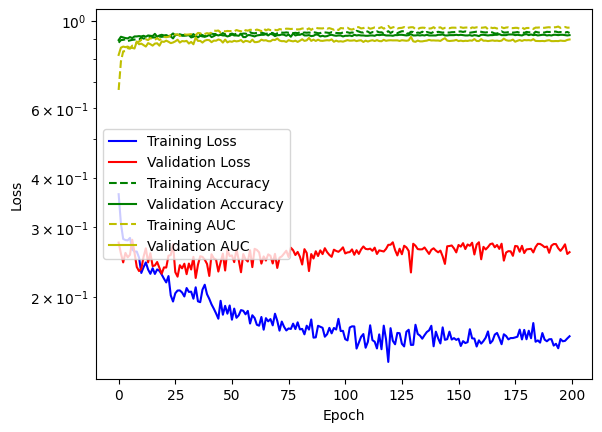

Epoch:0, Training_loss:0.3633, Training_acc:0.8790, Training_auc:0.6671, Training_bal_acc:0.5119, Eval_loss:0.2740, Eval_acc:0.8924, Eval_auc:0.8183, Eval_bal_acc:0.4990
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2220, Training_acc:0.9114, Training_auc:0.9087, Training_bal_acc:0.6886, Eval_loss:0.2371, Eval_acc:0.9167, Eval_auc:0.8830, Eval_bal_acc:0.7294
saving best...
saving best...
saving best...
Epoch:40, Training_loss:0.1974, Training_acc:0.9249, Training_auc:0.9264, Training_bal_acc:0.7335, Eval_loss:0.2256, Eval_acc:0.9201, Eval_auc:0.8918, Eval_bal_acc:0.7345
Epoch:60, Training_loss:0.1765, Training_acc:0.9280, Training_auc:0.9444, Training_bal_acc:0.7489, Eval_loss:0.2642, Eval_acc:0.9115, Eval_auc:0.8816, Eval_bal_acc:0.7517
Epoch:80, Training_loss:0.1652, Training_acc:0.9337, Training_auc:0.9503, Training_bal_acc:0.7665, Eval_loss:0.2524, Eval_acc:0.9201, Eval_auc:0.8891, Eval_bal_acc:0.7419
Epoch:100, 

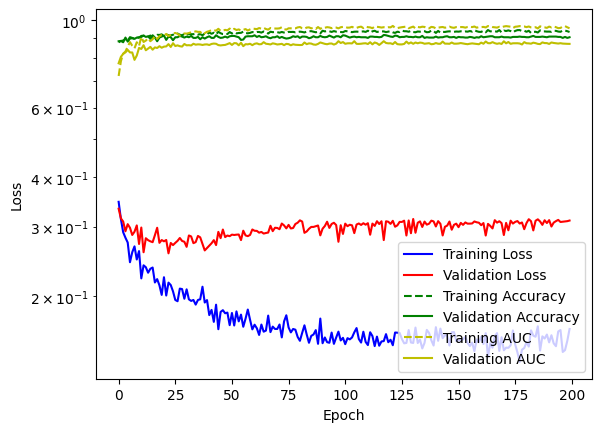

Epoch:0, Training_loss:0.3469, Training_acc:0.8782, Training_auc:0.7219, Training_bal_acc:0.5053, Eval_loss:0.3333, Eval_acc:0.8837, Eval_auc:0.7773, Eval_bal_acc:0.5270
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2236, Training_acc:0.9095, Training_auc:0.9130, Training_bal_acc:0.7077, Eval_loss:0.2757, Eval_acc:0.9132, Eval_auc:0.8564, Eval_bal_acc:0.6921
saving best...
saving best...
Epoch:40, Training_loss:0.1794, Training_acc:0.9297, Training_auc:0.9374, Training_bal_acc:0.7412, Eval_loss:0.2689, Eval_acc:0.9097, Eval_auc:0.8646, Eval_bal_acc:0.7004
saving best...
saving best...
Epoch:60, Training_loss:0.1696, Training_acc:0.9295, Training_auc:0.9499, Training_bal_acc:0.7562, Eval_loss:0.2931, Eval_acc:0.9149, Eval_auc:0.8706, Eval_bal_acc:0.7397
saving best...
Epoch:80, Training_loss:0.1545, Training_acc:0.9345, Training_auc:0.9600, Training_bal_acc:0.7947, Eval_loss:0.3115, Eval_acc:0.9010, Eva

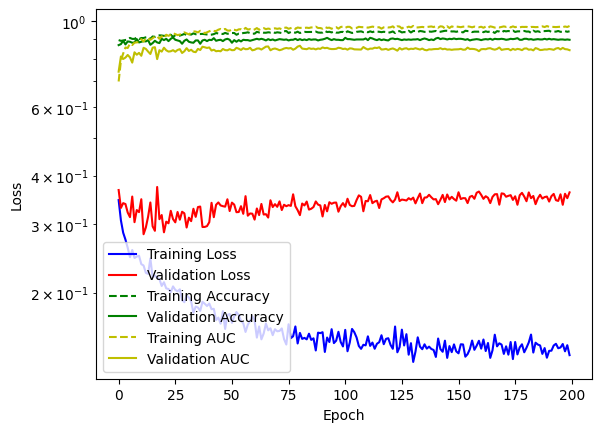

Epoch:0, Training_loss:0.3458, Training_acc:0.8925, Training_auc:0.6984, Training_bal_acc:0.5125, Eval_loss:0.3671, Eval_acc:0.8663, Eval_auc:0.7401, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2126, Training_acc:0.9150, Training_auc:0.9016, Training_bal_acc:0.6707, Eval_loss:0.2857, Eval_acc:0.8924, Eval_auc:0.8530, Eval_bal_acc:0.6728
saving best...
Epoch:40, Training_loss:0.1874, Training_acc:0.9209, Training_auc:0.9405, Training_bal_acc:0.7467, Eval_loss:0.3034, Eval_acc:0.8941, Eval_auc:0.8543, Eval_bal_acc:0.7009
Epoch:60, Training_loss:0.1693, Training_acc:0.9272, Training_auc:0.9505, Training_bal_acc:0.7554, Eval_loss:0.3081, Eval_acc:0.8958, Eval_auc:0.8427, Eval_bal_acc:0.7057
saving best...
saving best...
Epoch:80, Training_loss:0.1574, Training_acc:0.9306, Training_auc:0.9591, Training_bal_acc:0.7865, Eval_loss:0.3164, Eval_acc:0.8976, Eval_auc:0.8629, Eval_bal_acc:0.7

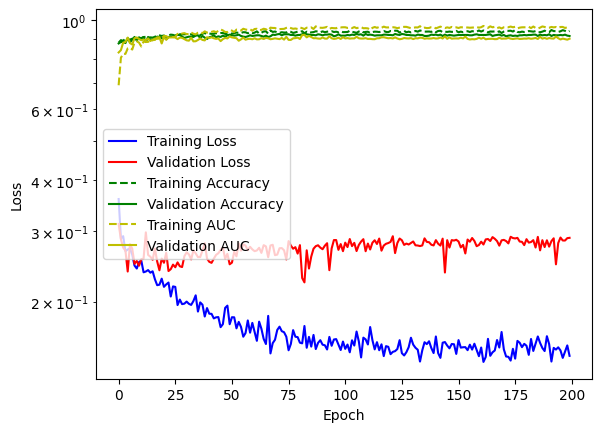

Epoch:0, Training_loss:0.3598, Training_acc:0.8788, Training_auc:0.6891, Training_bal_acc:0.5166, Eval_loss:0.3121, Eval_acc:0.8750, Eval_auc:0.8311, Eval_bal_acc:0.5298
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2179, Training_acc:0.9156, Training_auc:0.9133, Training_bal_acc:0.7090, Eval_loss:0.2500, Eval_acc:0.9115, Eval_auc:0.9077, Eval_bal_acc:0.7135
saving best...
Epoch:40, Training_loss:0.1868, Training_acc:0.9263, Training_auc:0.9310, Training_bal_acc:0.7269, Eval_loss:0.2514, Eval_acc:0.9062, Eval_auc:0.9025, Eval_bal_acc:0.7083
saving best...
Epoch:60, Training_loss:0.1686, Training_acc:0.9306, Training_auc:0.9502, Training_bal_acc:0.7626, Eval_loss:0.2671, Eval_acc:0.9149, Eval_auc:0.9013, Eval_bal_acc:0.7346
Epoch:80, Training_loss:0.1583, Training_acc:0.9339, Training_auc:0.9585, Training_bal_acc:0.7824, Eval_loss:0.2764, Eval_acc:0.9184, Eval_auc:0.8975, Eval_bal_acc:0.7

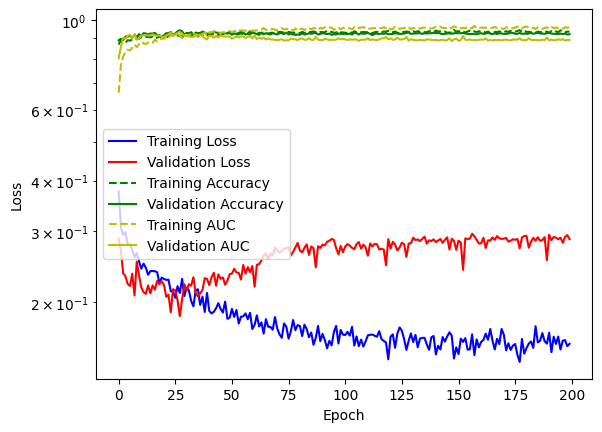

Epoch:0, Training_loss:0.3759, Training_acc:0.8683, Training_auc:0.6601, Training_bal_acc:0.4990, Eval_loss:0.2877, Eval_acc:0.8906, Eval_auc:0.8031, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2285, Training_acc:0.9082, Training_auc:0.8978, Training_bal_acc:0.6596, Eval_loss:0.2208, Eval_acc:0.9167, Eval_auc:0.9069, Eval_bal_acc:0.6627
saving best...
saving best...
Epoch:40, Training_loss:0.1905, Training_acc:0.9223, Training_auc:0.9323, Training_bal_acc:0.7303, Eval_loss:0.2206, Eval_acc:0.9253, Eval_auc:0.9143, Eval_bal_acc:0.7823
Epoch:60, Training_loss:0.1759, Training_acc:0.9287, Training_auc:0.9404, Training_bal_acc:0.7318, Eval_loss:0.2186, Eval_acc:0.9271, Eval_auc:0.9141, Eval_bal_acc:0.7384
Epoch:80, Training_loss:0.1748, Training_acc:0.9278, Training_auc:0.9493, Training_bal_acc:0.7536, Eval_loss:0.2688, Eval_acc:0.9184, Eval_auc:0.8987, Eval_bal_acc:0.7372
Epoch:100, Training_loss:0

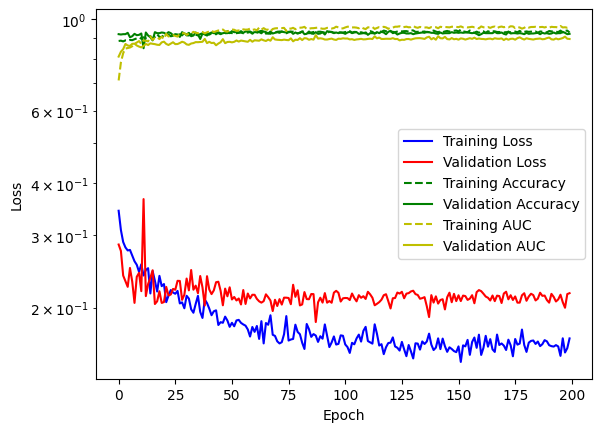

Epoch:0, Training_loss:0.3433, Training_acc:0.8859, Training_auc:0.7106, Training_bal_acc:0.5028, Eval_loss:0.2843, Eval_acc:0.9201, Eval_auc:0.8118, Eval_bal_acc:0.5399
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2280, Training_acc:0.9148, Training_auc:0.8957, Training_bal_acc:0.6962, Eval_loss:0.2062, Eval_acc:0.9271, Eval_auc:0.8824, Eval_bal_acc:0.7103
saving best...
saving best...
Epoch:40, Training_loss:0.1988, Training_acc:0.9177, Training_auc:0.9343, Training_bal_acc:0.7418, Eval_loss:0.2212, Eval_acc:0.9236, Eval_auc:0.8817, Eval_bal_acc:0.7361
Epoch:60, Training_loss:0.1746, Training_acc:0.9299, Training_auc:0.9450, Training_bal_acc:0.7706, Eval_loss:0.2147, Eval_acc:0.9306, Eval_auc:0.8892, Eval_bal_acc:0.7307
saving best...
Epoch:80, Training_loss:0.1723, Training_acc:0.9266, Training_auc:0.9537, Training_bal_acc:0.7859, Eval_loss:0.2024, Eval_acc:0.9288, Eval_auc:0.8999, E

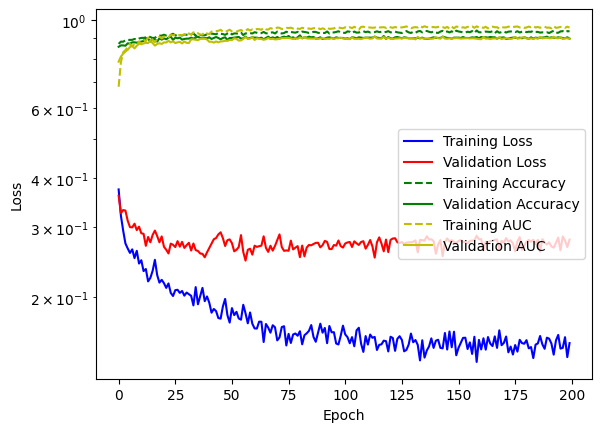

Epoch:0, Training_loss:0.3739, Training_acc:0.8721, Training_auc:0.6797, Training_bal_acc:0.5336, Eval_loss:0.3604, Eval_acc:0.8576, Eval_auc:0.7864, Eval_bal_acc:0.5000
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2166, Training_acc:0.9200, Training_auc:0.9090, Training_bal_acc:0.7073, Eval_loss:0.2678, Eval_acc:0.9010, Eval_auc:0.8797, Eval_bal_acc:0.7351
saving best...
saving best...
saving best...
saving best...
Epoch:40, Training_loss:0.1934, Training_acc:0.9228, Training_auc:0.9233, Training_bal_acc:0.7064, Eval_loss:0.2658, Eval_acc:0.9062, Eval_auc:0.8828, Eval_bal_acc:0.7306
saving best...
saving best...
Epoch:60, Training_loss:0.1665, Training_acc:0.9335, Training_auc:0.9458, Training_bal_acc:0.7524, Eval_loss:0.2694, Eval_acc:0.9045, Eval_auc:0.8923, Eval_bal_acc:0.7317
Epoch:80, Training_loss:0.1638, Training_acc:0.

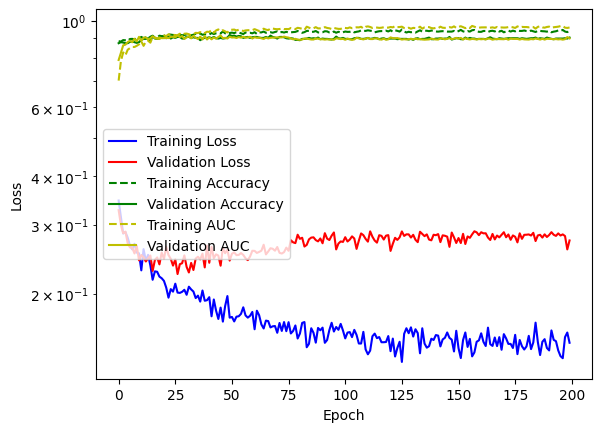

Epoch:0, Training_loss:0.3461, Training_acc:0.8857, Training_auc:0.7018, Training_bal_acc:0.5025, Eval_loss:0.3269, Eval_acc:0.8750, Eval_auc:0.7925, Eval_bal_acc:0.5135
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2154, Training_acc:0.9125, Training_auc:0.9155, Training_bal_acc:0.6959, Eval_loss:0.2454, Eval_acc:0.9115, Eval_auc:0.9016, Eval_bal_acc:0.7444
saving best...
Epoch:40, Training_loss:0.1958, Training_acc:0.9211, Training_auc:0.9350, Training_bal_acc:0.7528, Eval_loss:0.2398, Eval_acc:0.9062, Eval_auc:0.9056, Eval_bal_acc:0.7238
Epoch:60, Training_loss:0.1620, Training_acc:0.9335, Training_auc:0.9505, Training_bal_acc:0.7609, Eval_loss:0.2572, Eval_acc:0.9080, Eval_auc:0.9064, Eval_bal_acc:0.7341
Epoch:80, Training_loss:0.1580, Training_acc:0.9367, Training_auc:0.9557, Training_bal_acc:0.7811, Eval_loss:0.2761, Eval_acc:0.8906, Eval_auc:0.8925, Eval_bal_acc:0.6

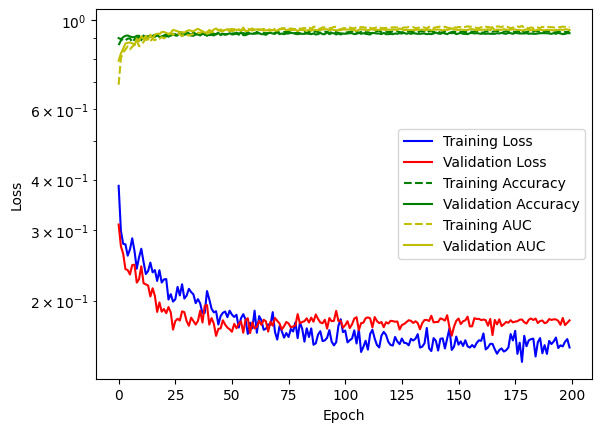

Epoch:0, Training_loss:0.3863, Training_acc:0.8659, Training_auc:0.6900, Training_bal_acc:0.5168, Eval_loss:0.3095, Eval_acc:0.9010, Eval_auc:0.7918, Eval_bal_acc:0.5169
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2260, Training_acc:0.9104, Training_auc:0.8999, Training_bal_acc:0.6920, Eval_loss:0.1907, Eval_acc:0.9149, Eval_auc:0.9339, Eval_bal_acc:0.7537
saving best...
saving best...
saving best...
saving best...
Epoch:40, Training_loss:0.2016, Training_acc:0.9186, Training_auc:0.9315, Training_bal_acc:0.7402, Eval_loss:0.1744, Eval_acc:0.9167, Eval_auc:0.9443, Eval_bal_acc:0.7728
saving best...
saving best...
Epoch:60, Training_loss:0.1888, Training_acc:0.9245, Training_auc:0.9435, Training_bal_acc:0.7717, Eval_loss:0.1705, Eval_acc:0.9253, Eval_auc:0.9466, Eval_bal_acc:0.7993
Epoch:80, Training_loss:0.1765, Training_acc:0.

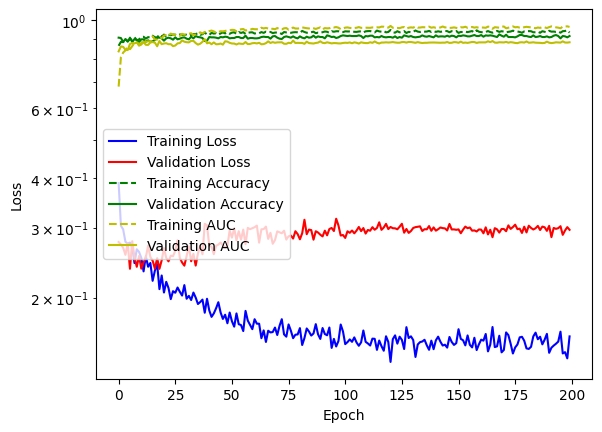

Epoch:0, Training_loss:0.3888, Training_acc:0.8628, Training_auc:0.6809, Training_bal_acc:0.5191, Eval_loss:0.2762, Eval_acc:0.9045, Eval_auc:0.8353, Eval_bal_acc:0.5249
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2060, Training_acc:0.9209, Training_auc:0.9159, Training_bal_acc:0.7234, Eval_loss:0.2667, Eval_acc:0.8889, Eval_auc:0.8745, Eval_bal_acc:0.7504
saving best...
saving best...
Epoch:40, Training_loss:0.1856, Training_acc:0.9192, Training_auc:0.9397, Training_bal_acc:0.7383, Eval_loss:0.2697, Eval_acc:0.9080, Eval_auc:0.8793, Eval_bal_acc:0.7804
Epoch:60, Training_loss:0.1764, Training_acc:0.9264, Training_auc:0.9500, Training_bal_acc:0.7616, Eval_loss:0.3009, Eval_acc:0.9010, Eval_auc:0.8769, Eval_bal_acc:0.7607
Epoch:80, Training_loss:0.1675, Training_acc:0.9308, Training_auc:0.9549, Training_bal_acc:0.7946, Eval_loss:0.2806, Eval_acc:0.9115, Eval_auc:0.8773, Eval_bal_acc:0.7555
Epoch:100, 

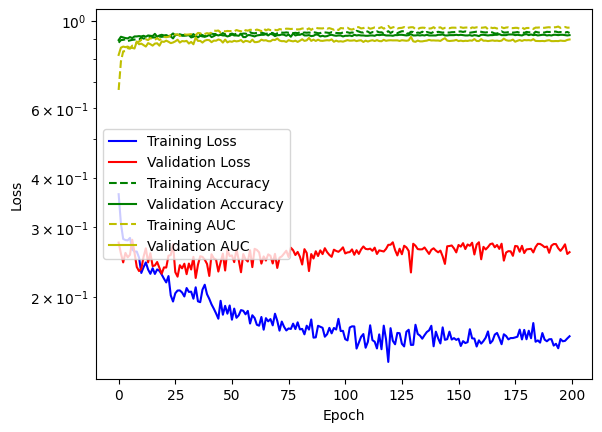

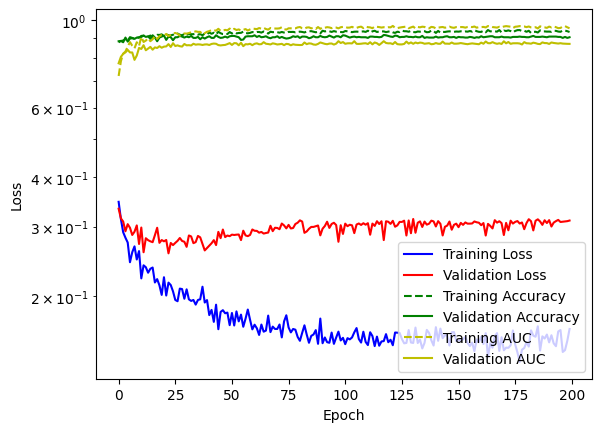

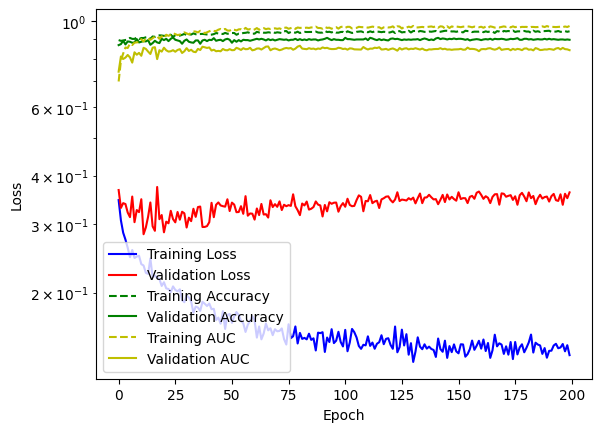

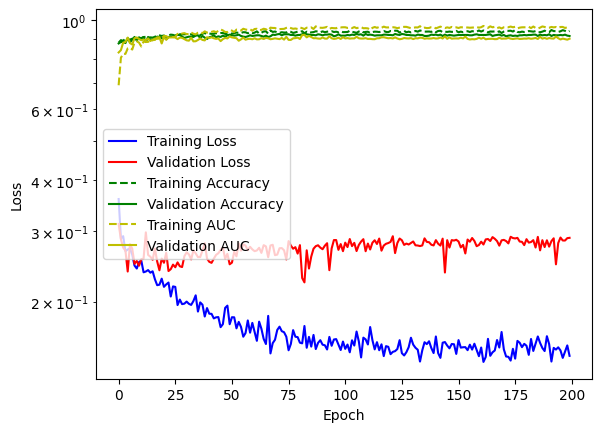

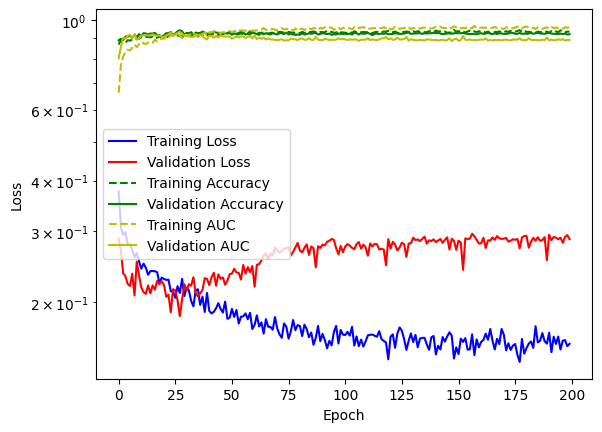

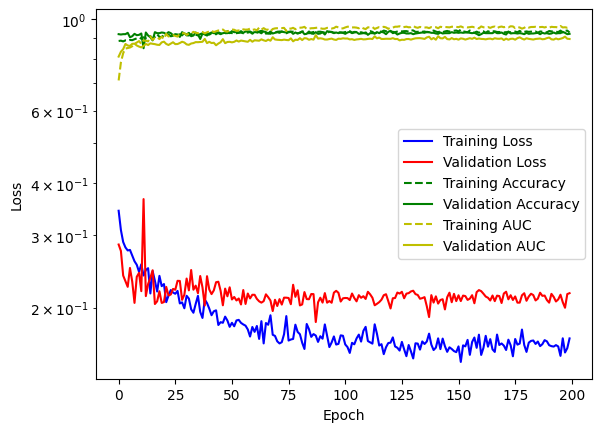

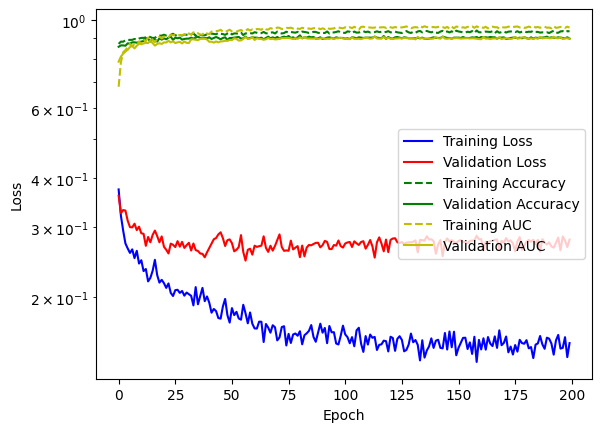

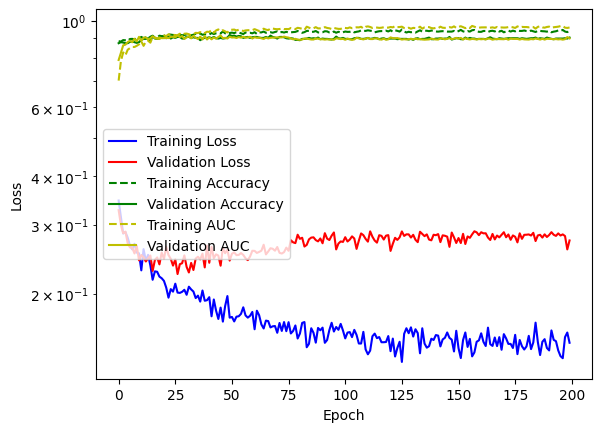

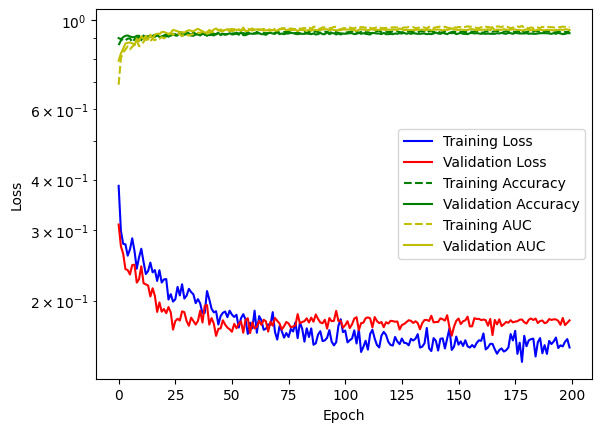

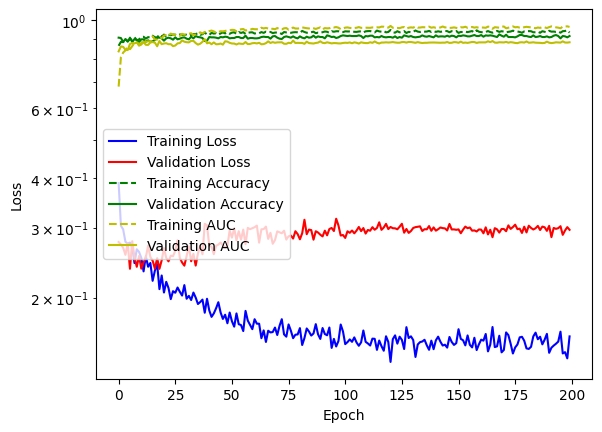

In [10]:
batch_size = 64

do = 0.2
num_layer = 3
num_hidden = 64
lr = 0.0005

best_acc_list = []
best_auc_list = []
best_bal_acc_list = []

for i, (train_index, test_index) in enumerate(skf.split(np.zeros(len(train_class_label)), train_class_label)):
    trainfold = train_set[train_index]
    valfold = train_set[test_index]
    train_sampler = ImbalancedSampler(torch.tensor([0 if e==[1,0] else 1 for e in trainfold.y.view(-1,2)], dtype=torch.long))
    train_dataloader = DataLoader(trainfold, batch_size=batch_size, sampler=train_sampler, drop_last=True, worker_init_fn=seed_worker,generator=g)
    val_dataloader = DataLoader(valfold, batch_size=batch_size, shuffle=True, drop_last=True, worker_init_fn=seed_worker,generator=g)

    model = simpleGIN(in_channels=trainfold[0].x.size(1), dim_h=num_hidden, out_channels=trainfold[0].y.size(0), num_layers=num_layer, dropout=do).to(device)

    trainer = Trainer(model=model,
                      train_loader=train_dataloader,
                      val_loader=val_dataloader,
                      test_loader=None,
                      device=device,
                      save_dir=os.path.join(os.getcwd(),'models/GIN/cross-val'),
                      save_name='GIN_' + str(i))
    train_params = {'num_epochs': 200,
                    'num_early_stop': 0,
                    'step': 20,
                    'gamma': 0.5}
                    
    optimizer_params = {'lr': lr,
                        'weight_decay': 1e-5}
                    
    best_eval_acc, best_eval_auc, best_eval_bal_acc = trainer.train(train_params=train_params, optimizer_params=optimizer_params, verbose=True,)
    best_acc_list.append(best_eval_acc)
    best_auc_list.append(best_eval_auc)
    best_bal_acc_list.append(best_eval_bal_acc)

In [11]:
print(f'The model achieves accuracy={np.mean(best_acc_list):.4f}±{np.std(best_acc_list):.4f}, AUC={np.mean(best_auc_list):.4f}±{np.std(best_auc_list):.4f}' 
      f' and balanced accuracy={np.mean(best_bal_acc_list):.4f}±{np.std(best_bal_acc_list):.4f}')

The model achieves accuracy=0.9118±0.0103, AUC=0.8916±0.0248 and balanced accuracy=0.7434±0.0309


## 3. Evaluate Test Set
<a id='test'></a>

As a last step we train the model one last time on a radom subset of the training data (keeping 15% for validation) and then evaluate the test set with the model and compute the confusion matrix, the ROC curve and the Precision-Recall curve

In [5]:
from models import simpleGIN

batch_size = 64

do = 0.2
num_layer = 3
num_hidden = 64
lr = 0.0005

train_final, _ , val_final = random_split_dataset(train_set, frac_train=0.85, frac_val=0.0, frac_test=0.15)

train_sampler = ImbalancedSampler(torch.tensor([0 if e==[1,0] else 1 for e in train_final.y.view(-1,2)], dtype=torch.long))
train_dataloader = DataLoader(train_final, batch_size=batch_size, sampler=train_sampler, drop_last=True, worker_init_fn=seed_worker,generator=g)
val_dataloader = DataLoader(val_final, batch_size=batch_size, shuffle=True, drop_last=True, worker_init_fn=seed_worker,generator=g)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True, worker_init_fn=seed_worker,generator=g)

model = simpleGIN(in_channels=train_final[0].x.size(1), dim_h=num_hidden, out_channels=train_final[0].y.size(0), num_layers=num_layer, dropout=do).to(device)

trainer = Trainer(model=model,
                  train_loader=train_dataloader,
                  val_loader=val_dataloader,
                  test_loader=test_dataloader,
                  device=device,
                  save_dir=os.path.join(os.getcwd(),'models/final'),
                  save_name='GIN')

train_params = {'num_epochs': 200,
                'num_early_stop': 0,
                'step': 20,
                'gamma': 0.5}
                    
optimizer_params = {'lr': lr,
                    'weight_decay': 1e-5}

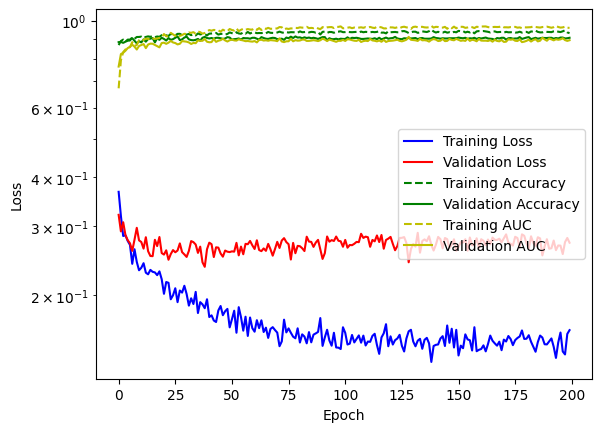

Epoch:0, Training_loss:0.3665, Training_acc:0.8660, Training_auc:0.6722, Training_bal_acc:0.5095, Eval_loss:0.3202, Eval_acc:0.8810, Eval_auc:0.7635, Eval_bal_acc:0.5300
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:20, Training_loss:0.2015, Training_acc:0.9183, Training_auc:0.9240, Training_bal_acc:0.7146, Eval_loss:0.2537, Eval_acc:0.8978, Eval_auc:0.8783, Eval_bal_acc:0.7105
saving best...
saving best...
saving best...
saving best...
saving best...
Epoch:40, Training_loss:0.1759, Training_acc:0.9261, Training_auc:0.9457, Training_bal_acc:0.7385, Eval_loss:0.2720, Eval_acc:0.9002, Eval_auc:0.8804, Eval_bal_acc:0.7256
saving best...
saving best...
Epoch:60, Training_loss:0.1614, Training_acc:0.9329, Training_auc:0.9560, Training_bal_acc:0.7722, Eval_loss:0.2621, Eval_acc:0.9038, Eval_auc:0.8867, Eval_bal_acc:0.7416
saving best...
Epoch:80, Training_loss:0.1515, Training_acc:0.

ValueError: not enough values to unpack (expected 7, got 6)

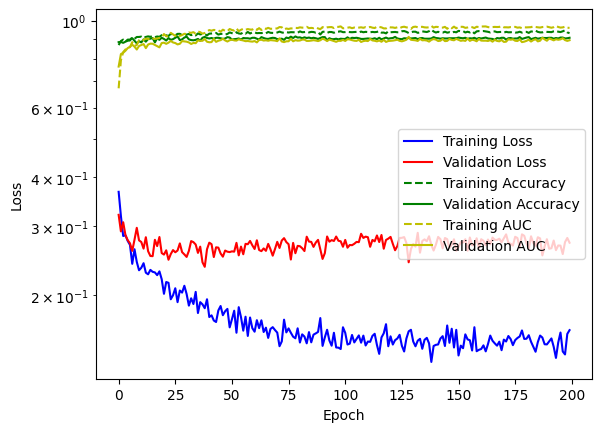

In [13]:
best_eval_acc, best_eval_auc, best_eval_bal_acc = trainer.train(train_params=train_params, optimizer_params=optimizer_params, verbose=True,)
test_loss, test_acc, test_auc, test_bal_acc ,preds, pred_probs, labels = trainer.test()

In [6]:
trainer.load_model()

test_loss, test_acc, test_auc , test_bal_acc, preds, pred_probs, labels = trainer.test()
# print(balanced_accuracy_score(labels, preds).item())

Test loss: 0.3370, test acc 0.8938, test_auc 0.8697, test_bal_acc 0.7295


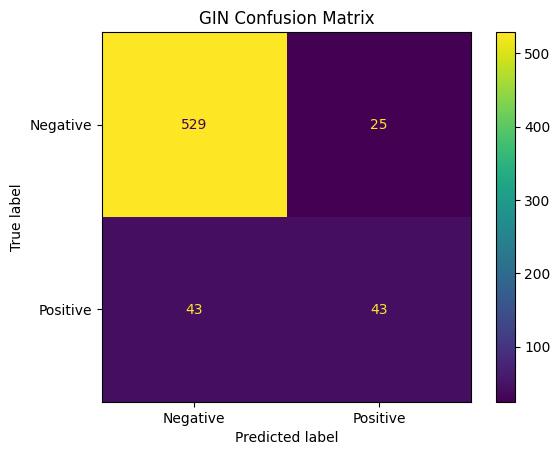

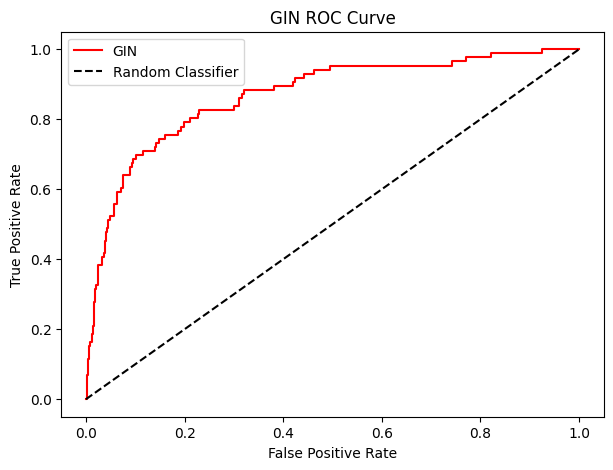

In [19]:
# Confusion matrix
c_matrix = confusion_matrix(labels.numpy(), preds)
disp = ConfusionMatrixDisplay(
    c_matrix, display_labels=["Negative","Positive"]
)
disp.plot() 
plt.title("GIN Confusion Matrix") 
plt.savefig('GIN_confusion.pdf')
plt.show()

# AUC by class
y_true_bin = label_binarize(labels.numpy(), classes=np.arange(2))
plt.figure(figsize=(7,5))
fpr, tpr, _ = roc_curve(y_true_bin[:, 0], pred_probs.numpy())
plt.plot(fpr, tpr, "r-", label="GIN")
plt.plot([0,1], [0,1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("GIN ROC Curve") 
plt.legend() 
plt.savefig('GIN_ROC.pdf')
plt.show()

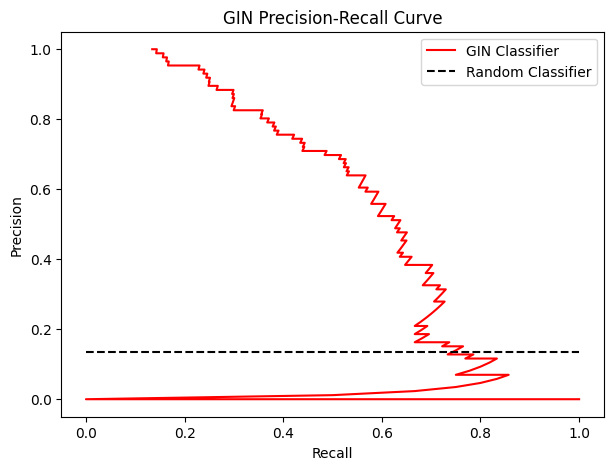

In [20]:
# AUC by class
pos_ratio = y_true_bin.sum().item()/len(y_true_bin)
y_true_bin = label_binarize(labels.numpy(), classes=np.arange(2))
plt.figure(figsize=(7,5))
fpr, tpr, _ = precision_recall_curve(y_true_bin[:, 0], pred_probs.numpy())
plt.plot(fpr, tpr, "r-", label="GIN Classifier")
plt.plot([0,1], [pos_ratio,pos_ratio], "k--", label="Random Classifier")
plt.xlabel("Recall") 
plt.ylabel("Precision")
plt.title("GIN Precision-Recall Curve") 
plt.legend() 
plt.savefig('GIN_PR_curve.pdf')
plt.show()